Test performance of Trotterization on the classical computer  
Modified by Jungyoung Kim at 2021-06-30

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.opflow import I,X,Y,Z,CX,H,Zero,StateFn,PauliTrotterEvolution,PauliExpectation,Suzuki,One
from qiskit.circuit import Parameter

/home/jungyoung/.local/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [21]:
plt.rcParams['font.family'] = 'Serif'
plt.rcParams['font.size'] = 10

In [22]:
np.random.seed(1000)

In [35]:
## Get Unitary evolution operator for parameter 't'
# Set Hamiltonian
H_no_field = (0.5*X^X) + (0.5*Y^Y) + (0.5*Z^Z)
H_with_field = (0.5*X^X) + (0.5*Y^Y) + (0.5*Z^Z) + (0.5*Z^I) + (0.5*I^Z) 

param_t = Parameter('t')
eop_no_field = (param_t * H_no_field).exp_i()
eop_with_field = (param_t * H_with_field).exp_i()

In [87]:
measures[0]

OperatorStateFn(PauliOp(Pauli('ZI'), coeff=1.0), coeff=1.0, is_measurement=True)

[0.318, 0.031, 0.751, 0.577]
0 done
1 done
2 done
3 done
4 done
5 done


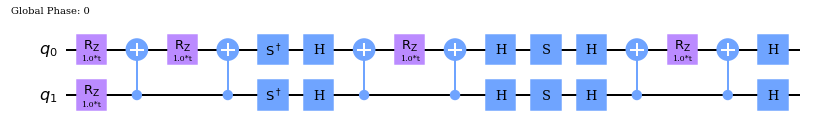

In [80]:
measures = []
measures.append(StateFn(Z^I).adjoint())
measures.append(StateFn(I^Z).adjoint())
measures.append(StateFn(X^I).adjoint())
measures.append(StateFn(I^X).adjoint())
measures.append(StateFn(Y^I).adjoint())
measures.append(StateFn(I^Y).adjoint())

# create initial state
# v = np.random.uniform(size=4)
# v = v/np.sqrt(sum(v**2))
# init_state = StateFn(v)

# init_state = (CX @ (I^H) @ One)
v = [0.318, 0.031, 0.751, 0.577]
init_state = StateFn(v)

print(v)

# evolution time
t_pts_sample = list(np.linspace(0, 50, 5000))
yvals = []

for i in range(6):
    """ Using Hamiltonian with Z field """
#     op = measures[i] @ eop_no_field @ init_state
    op = measures[i] @ eop_with_field @ init_state
    # get Trotterization op
    trot_op = PauliTrotterEvolution(Suzuki(order=1, reps=1)).convert(op)
    diag_trot_op = PauliExpectation().convert(trot_op)
    exp = diag_trot_op.bind_parameters({param_t: t_pts_sample})
    yvals.append(exp.eval())

    print("%d done"%(i))

trot_op[1].to_circuit().draw('mpl')

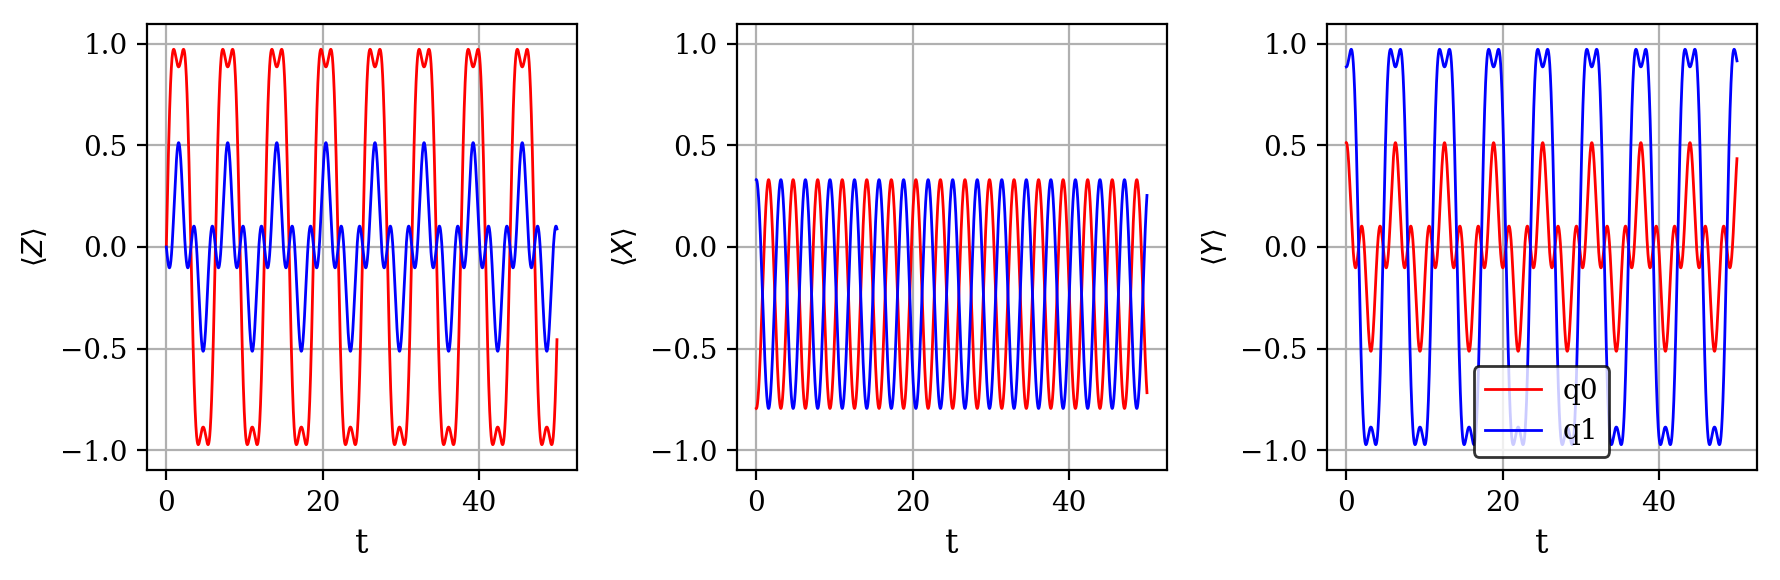

In [82]:
labels = ['q0', 'q1']
axis = ['Z', 'X', 'Y']
cs = ['r', 'b']

plt.figure(dpi=200, figsize=(9,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    for j in range(2):
        plt.plot(t_pts_sample, np.real(yvals[2*(i-1)+j]), label='%s'%(labels[j]), lw=1, color=cs[j])
#         plt.text(-4., 1., cap[i])
    plt.xlabel('t', fontsize=12)
    plt.ylabel(r'$\langle %s \rangle$'%(axis[i]))
    plt.ylim(-1.1, 1.1)
    plt.grid(True)
plt.legend(loc='best', edgecolor='k', )
plt.tight_layout()
plt.show()

In [100]:
# export data
from scipy.io import savemat

data = {'t': t_pts_sample, 'y': yvals}

savemat('./sample_two_qbuit_XYZ.mat', data)

In [84]:
## Iterate for each states
def get_init_state():
    v = np.random.uniform(size=4)
    v = v/np.sqrt(sum(v**2))
    return StateFn(v)

init_states = []
# state1: Bell state
init_states.append((CX @ (I^H) @ Zero))

# state2,3: randomized init state
for i in range(2):
    init_states.append(get_init_state())

In [91]:
# Run
measures = []
measures.append(StateFn(Z^I).adjoint())
measures.append(StateFn(I^Z).adjoint())
measures.append(StateFn(X^I).adjoint())
measures.append(StateFn(I^X).adjoint())
measures.append(StateFn(Y^I).adjoint())
measures.append(StateFn(I^Y).adjoint())

# evolution time
t_pts = list(np.linspace(0, 10, 100))
results = []

for n in range(3): # iterate for each init state
    results.append([])
    for i in range(6):
        op = measures[i] @ eop_with_field @ init_states[n]
        trot_op = PauliTrotterEvolution(Suzuki(order=1, reps=1)).convert(op)
        diag_trot_op = PauliExpectation().convert(trot_op)
        exp = diag_trot_op.bind_parameters({param_t: t_pts})
        results[-1].append(exp.eval())
    print("init_state%d done"%(n))
    

init_state0 done
init_state1 done
init_state2 done


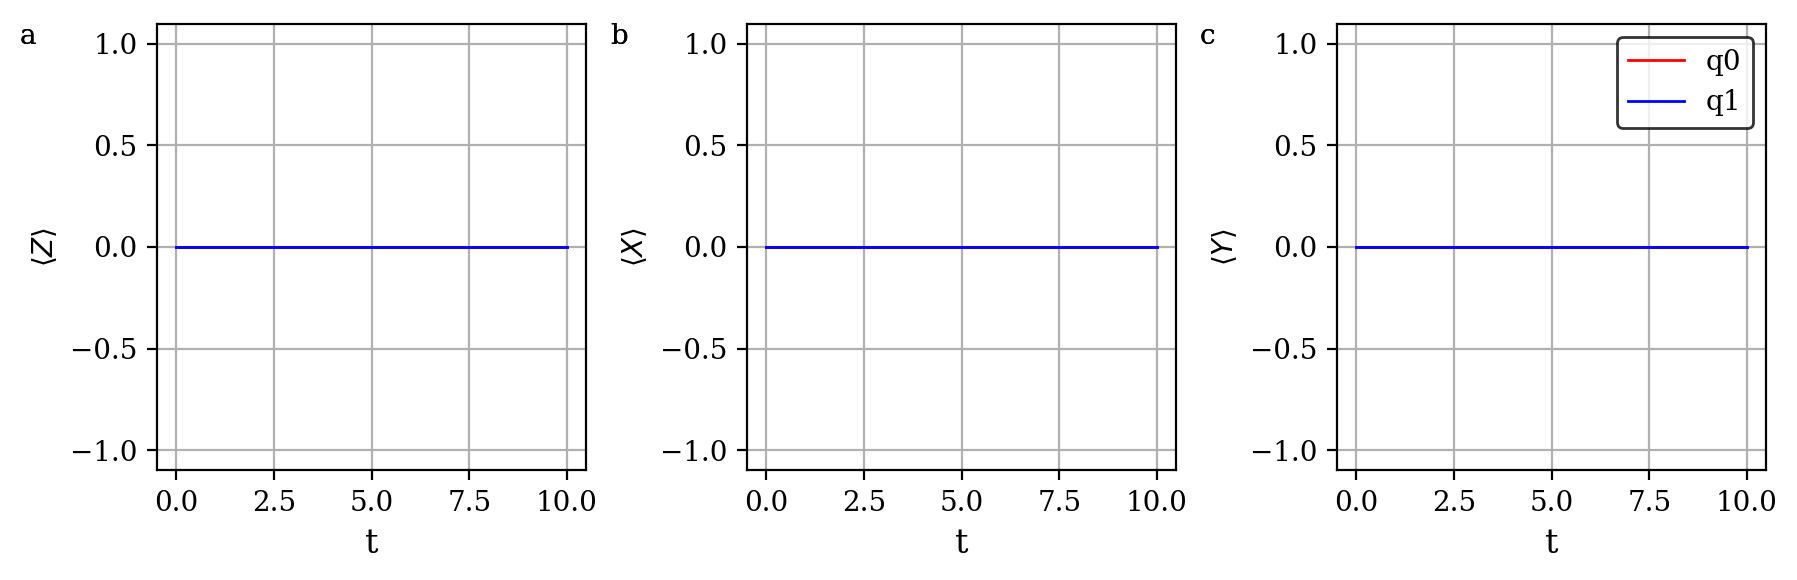

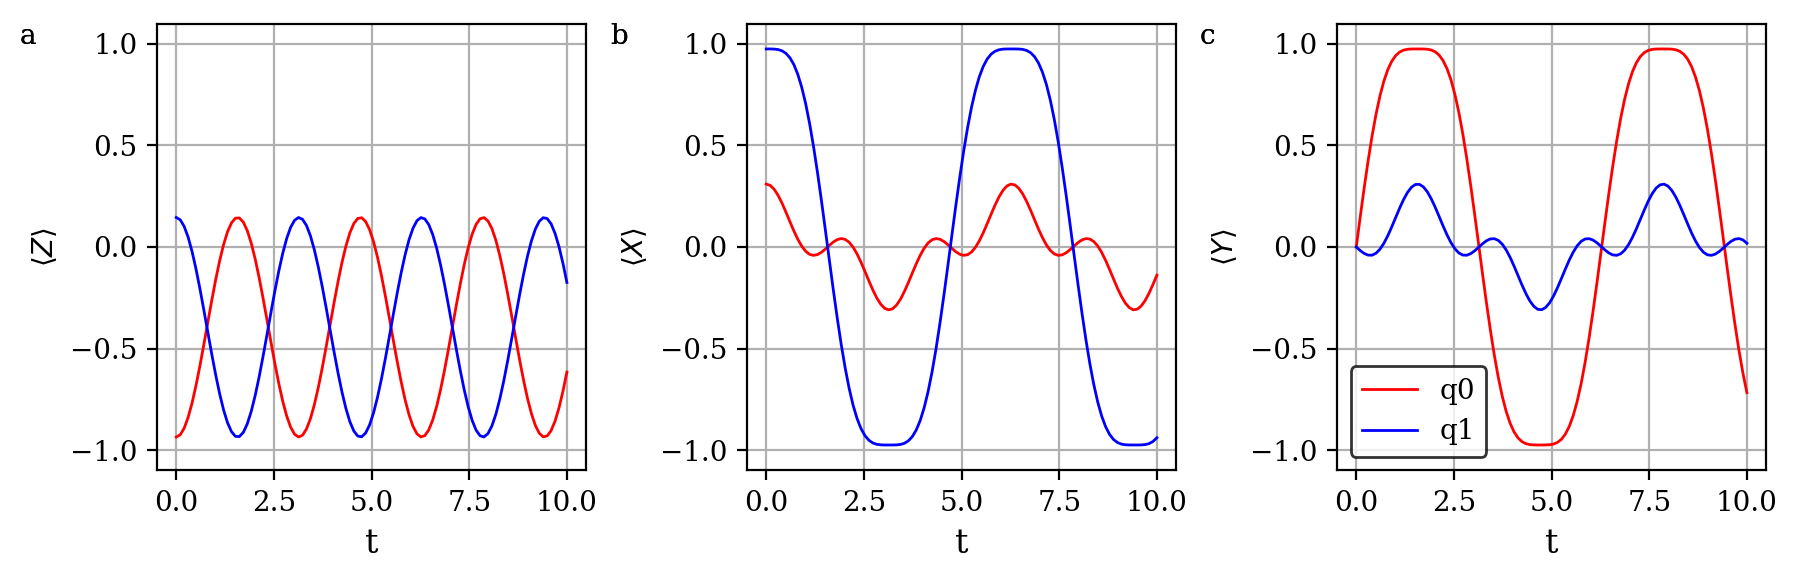

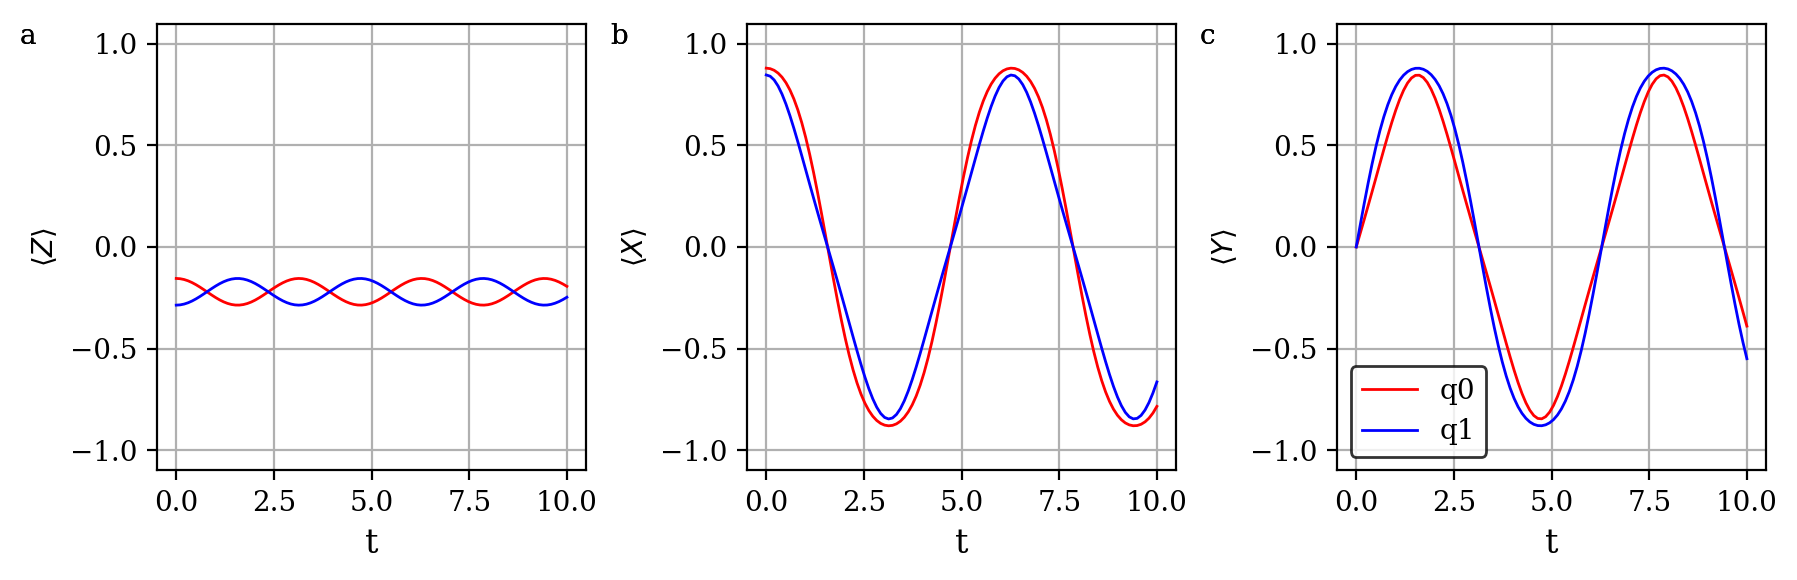

In [97]:
labels = ['q0', 'q1']
axis = ['Z', 'X', 'Y']
cs = ['r', 'b']
cap = ['a', 'b', 'c']

for n in range(3):
    # create figures
    plt.figure(dpi=200, figsize=(9,3))
    for i in range(3):
        plt.subplot(1,3,i+1)
        for j in range(2):
            plt.plot(t_pts, results[n][2*i+j], label='%s'%(labels[j]), lw=1, color=cs[j])
            plt.text(-4., 1., cap[i])
        plt.xlabel('t', fontsize=12)
        plt.ylabel(r'$\langle %s \rangle$'%(axis[i]))
        plt.ylim(-1.1, 1.1)
        plt.grid(True)
    plt.legend(loc='best', edgecolor='k', )
    plt.tight_layout()
    plt.show()

In [99]:
init_states[2]

VectorStateFn(Statevector([0.50811745+0.j, 0.4053911 +0.j, 0.3141061 +0.j,
             0.69196248+0.j],
            dims=(2, 2)), coeff=1.0, is_measurement=False)

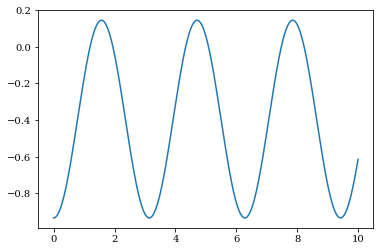

In [96]:
plt.plot(t_pts_sample, yy)

In [69]:
init_states[2]

VectorStateFn(Statevector([0.4848187 +0.j, 0.35083952+0.j, 0.56042724+0.j,
             0.57252403+0.j],
            dims=(2, 2)), coeff=1.0, is_measurement=False)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


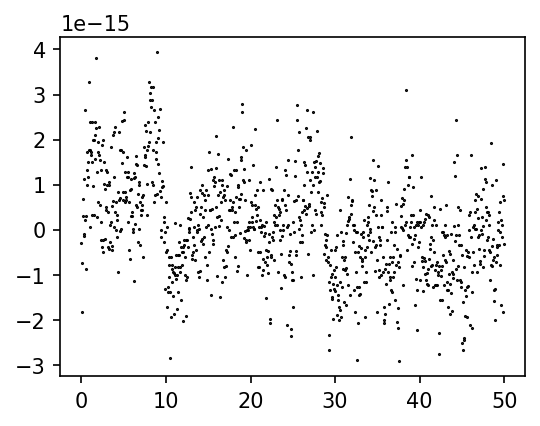

In [ ]:
i = 2
j = 2

plt.figure(dpi=150, figsize=(4, 3))
plt.plot(t_pts, results[i,j,:], 'k.', ms=1)
plt.show()